In [ ]:
!pip install reservoirpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 167 kB 4.0 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from reservoirpy import nodes, mat_gen
import math
from sklearn.metrics import r2_score

In [ ]:
def lorenz(x, y, z, s=10, r=28, b=2.667):
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

In [ ]:
dt = 0.01
num_steps = 10000
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

xs[0], ys[0], zs[0] = (0., 1., 1.05)

for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)

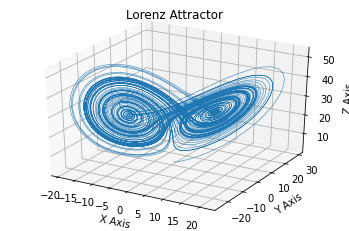

In [ ]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [ ]:
def plot_timeseries(xs,ys,zs):
    plt.plot(xs[:5000],label='x')
    plt.plot(ys[:5000],label='y') 
    plt.plot(zs[:5000],label='z')
    plt.show()

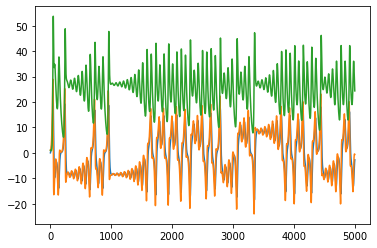

In [ ]:
plot_timeseries(xs,ys,zs)

In [ ]:
xs = (xs - np.mean(xs)) / np.std(xs)
ys = (ys - np.mean(ys)) / np.std(ys)
zs = (zs - np.mean(zs)) / np.std(zs)

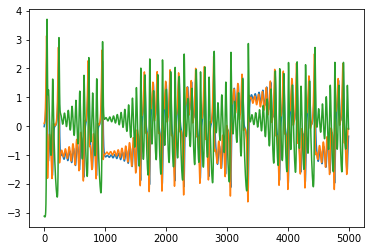

In [ ]:
plot_timeseries(xs,ys,zs)

In [ ]:
def make_data(trainLen,xs=xs,ys=ys,zs=zs):
  train_in = np.array((xs[:trainLen],ys[:trainLen],zs[:trainLen])).T
  train_out = np.array((xs[1:trainLen+1],ys[1:trainLen+1],zs[1:trainLen+1])).T
  validation_data = np.array((xs[trainLen+1:],ys[trainLen+1:],zs[trainLen+1:])).T
  return train_in , train_out, validation_data

In [ ]:
train_in, train_out, validation_data = make_data(trainLen=5000)
print(train_in.shape, train_out.shape, validation_data.shape)

(5000, 3) (5000, 3) (5000, 3)


In [ ]:
def Reservoir(train_in, train_out, validation_data, n_reservoir=2000, spectral_radius=1.5, input_scaling=1, leak_rate=0.15, input_bias=True, 
                        regularization_coef=0.00001, initLen=0, verbose_mode=True, workers=1, proba=0.2 ,seed=42):
 
    W = mat_gen.fast_spectral_initialization(N=n_reservoir, sr=spectral_radius, proba=proba, seed=seed)
    Win = mat_gen.generate_input_weights(N=n_reservoir, dim_input=train_in.shape[1], input_bias=input_bias, 
                                 input_scaling=input_scaling, proba=proba, seed=seed)

    reservoir = ESN(lr=leak_rate, W=W, Win=Win, input_bias=input_bias, ridge=regularization_coef)

    reservoir.train(inputs=[train_in], teachers=[train_out], wash_nr_time_step=initLen, verbose=verbose_mode, workers=workers)
    outputs, states, warming_outputs, warming_states = reservoir.generate(len(validation_data), warming_inputs=train_in[:])   
    outputs = (outputs - np.mean(outputs)) / np.std(outputs)
    
    return outputs

In [ ]:
def plot_histogram(forecast, target, label):
    plt.figure(figsize=(4.135,4.135)) 
    plt.hist(forecast, bins = 100, range=(np.min(target),np.max(target)), color='red', zorder=2, label = 'RCM', alpha = 0.5)
    plt.hist(target, bins= 100, zorder=1, label = 'real timeseries')
    plt.xlabel(label)
    plt.ylabel("Frequency of occurence")
    plt.legend(loc='upper left')
    plt.tight_layout(pad = 0.4)
    plt.show()

In [ ]:
def plot_PDF(forecast, target, label):
    plt.figure(figsize=(4.135,4.135))  
    n_real,bins = np.histogram(target,bins=100,density=True)
    bins_mean = [0.5*(bins[i]+bins[i+1]) for i in range(len(n_real))]
    plt.scatter( bins_mean, n_real, zorder=1, label = 'real timeseries')
    
    x = np.linspace(np.min(bins_mean),np.max(bins_mean),len(bins_mean))
    pdfx = np.multiply(1/np.sqrt(2*math.pi),np.exp(-(x**2)/2))
    plt.plot( x, pdfx, color='green', zorder=2, label = 'Gaussian')
    
    n_forecast,bins = np.histogram(forecast,bins=bins,density=True)
    plt.scatter(bins_mean, n_forecast, color='red', zorder=3, label = 'RCM', alpha = 0.5)
    plt.yscale('log')
    min_val = 100
    for i in n_real:
        if min_val > i and i > 0:
            min_val = i
    plt.ylim(ymin=min_val/10)
    plt.xlabel(label)
    plt.ylabel("Probability Density")
    plt.legend(loc='lower center')
    plt.tight_layout(pad = 0.4)
    plt.show()

In [ ]:
def plot_forecast(forecast, target, label, train_data):
    fig, axs = plt.subplots(1,2,gridspec_kw={'width_ratios': [4, 1]},figsize=(8.27,2.0675)) 
        
    offset = 0 
    plot_length = 1000  
    preview = 250 
    train_length = len(train_data)    
    x_data = range(preview+plot_length+1) 
    axs[0].plot(x_data[preview:], forecast[:plot_length+1], color='red', lw=1.5, label="forecast")
    axs[0].plot(x_data[:], np.concatenate((train_data[train_length-preview:], target[offset:offset+plot_length+1])), lw=0.75, label="real timeseries")
    axs[0].axvspan(0, preview, alpha=0.2, color='green')
    axs[0].margins(0)   
    axs[0].set_xticks([0,preview,preview+plot_length//4,preview+plot_length//2,preview+plot_length*3//4,preview+plot_length])
    axs[0].set_xticklabels([train_length-preview,train_length+offset+0,train_length+offset+plot_length//4,train_length+offset+plot_length//2,train_length+offset+plot_length*3//4,train_length+offset+plot_length])
    axs[0].set_xlabel("t")
    axs[0].set_ylabel(label)   
    axs[0].legend(ncol=2)
    
    plot_length = 40  
    preview = 10 
    x_data = range(preview+plot_length+1) 
    axs[1].plot(x_data[preview:], forecast[:plot_length+1], color='red', lw=1.5, label="forecast", marker = '.')
    axs[1].plot(x_data[:], np.concatenate((train_data[len(train_data)-preview:], target[offset:offset+plot_length+1])), lw=0.75, label="real timeseries", marker = ".")
    axs[1].axvspan(0, preview, alpha=0.2, color='green')
    axs[1].margins(0)
    axs[1].set_xlabel("t")
    axs[1].set_xticks([0,preview,preview+plot_length//4,preview+plot_length//2,preview+plot_length*3//4,preview+plot_length])
    axs[1].set_yticks([])
    axs[1].set_xticklabels([None,train_length+offset+0,None,train_length+offset+plot_length//2,None,train_length+offset+plot_length])
    plt.tight_layout(pad=0.4)
    plt.show()

In [ ]:
def MAPE(forecast,validation_data):
    MAPE_X = np.mean(np.abs((validation_data[:,0] - forecast[:,0]) / validation_data[:,0])) * 100
    MAPE_Y = np.mean(np.abs((validation_data[:,1] - forecast[:,1]) / validation_data[:,1])) * 100
    MAPE_Z = np.mean(np.abs((validation_data[:,2] - forecast[:,2]) / validation_data[:,2])) * 100
    return (MAPE_X, MAPE_Y, MAPE_Z)

In [ ]:
def R2(forecast, validation_data):
    R2_X = r2_score(forecast[:,0],validation_data[:,0])
    R2_Y = r2_score(forecast[:,1],validation_data[:,1])
    R2_Z = r2_score(forecast[:,2],validation_data[:,2])
    return (R2_X, R2_Y, R2_Z)

In [ ]:
def KL_Divergence(forecast, validation_data):
    # X-Direction
    n_real,bins = np.histogram(validation_data[:,0],bins=100,density=True)
    n_forecast,bins = np.histogram(forecast[:,0],bins=bins,density=True)
    q = n_forecast+1e-16
    p = n_real+1e-16
    KL_Divergence_X = np.sum(np.multiply(p,np.log(np.divide(p,q))))
    
    # Y-Direction
    n_real,bins = np.histogram(validation_data[:,1],bins=100,density=True)
    n_forecast,bins = np.histogram(forecast[:,1],bins=bins,density=True)
    q = n_forecast+1e-16
    p = n_real+1e-16
    KL_Divergence_Y = np.sum(np.multiply(p,np.log(np.divide(p,q))))
    
    # Z-Direction
    n_real,bins = np.histogram(validation_data[:,2],bins=100,density=True)
    n_forecast,bins = np.histogram(forecast[:,2],bins=bins,density=True)
    q = n_forecast+1e-16
    p = n_real+1e-16
    KL_Divergence_Z = np.sum(np.multiply(p,np.log(np.divide(p,q))))
    
    return (KL_Divergence_X, KL_Divergence_Y, KL_Divergence_Z)
    

In [ ]:
def metrics(forecast, validation_data):
    short_term_MAPE = MAPE(forecast[:50,:], validation_data[:50,:])
    mid_term_MAPE = MAPE(forecast[:500,:], validation_data[:500,:])
    long_term_MAPE = MAPE(forecast, validation_data)
    
    short_term_R2 = R2(forecast[:50,:], validation_data[:50,:])
    mid_term_R2 = R2(forecast[:500,:], validation_data[:500,:])
    long_term_R2 = R2(forecast, validation_data)
    
    short_term_KL_Divergence = KL_Divergence(forecast[:50,:], validation_data[:50,:])
    mid_term_KL_Divergence = KL_Divergence(forecast[:500,:], validation_data[:500,:])
    long_term_KL_Divergence = KL_Divergence(forecast, validation_data)
    
    return (short_term_MAPE, mid_term_MAPE, long_term_MAPE), (short_term_R2, mid_term_R2, long_term_R2), (short_term_KL_Divergence, mid_term_KL_Divergence, long_term_KL_Divergence)
    

In [ ]:
def ESN_Experiment(train_in, train_out, validation_data, N_Values, Spectral_Radius_Values, Leak_Rate_Values, Ridge_Regression_Values):
    best_long_term_KL_div_x = 100
    experiment_number = 0
    for N in N_Values:
        for S in Spectral_Radius_Values:
            for L in Leak_Rate_Values:
                for R in Ridge_Regression_Values:
                    reservoir_forecast = Reservoir(train_in, train_out, validation_data, n_reservoir=N, spectral_radius=S, input_scaling=1, leak_rate=L, input_bias=True, regularization_coef=R, initLen=0, verbose_mode=True, workers=1, proba=0.2 ,seed=42)
                    MAPE_Array, R2_Array, KL_Divergence_Array = metrics(reservoir_forecast, validation_data)
                    if R2_Array[1][1]<best_long_term_KL_div_x: 
                        best_long_term_KL_div_x = KL_Divergence_Array[2][0]
                        best_N = N
                        best_S = S
                        best_L = L
                        best_R = R
                    print('Trial ', experiment_number)
                    experiment_number+=1
    return best_N, best_S, best_L, best_R

In [ ]:
!pip install pyESN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyESN
from pyESN import ESN
N_Values = [500, 1000, 2000]
Spectral_Radius_Values = [0.5,1,1.5]
Leak_Rate_Values = [0.05,0.1,0.15]
Ridge_Regression_Values = [0.00005, 0.0001, 0.00015]

best_N, best_S, best_L, best_R=ESN_Experiment(train_in, train_out, validation_data, N_Values, Spectral_Radius_Values, Leak_Rate_Values, Ridge_Regression_Values)

print('Here are the best Hyperparameters for the ESN:\n Number of Nodes: ',best_N,'\n Spectral_Radius: ',best_S,'\n Leak_Rate: ', best_L, '\n Ridgre Regression Parameter: ',best_R)

In [ ]:
reservoir_forecast = Reservoir(train_in, train_out, validation_data, n_reservoir=best_N, spectral_radius=best_S, input_scaling=1, leak_rate=best_L, input_bias=True, regularization_coef=best_R, initLen=0, verbose_mode=True, workers=1, proba=0.2 ,seed=42)

Training on 1 inputs (5000 steps) -- wash: 0 steps


In [ ]:
MAPE_Array, R2_Array, KL_Divergence_Array = metrics(reservoir_forecast, validation_data)
print('MAPE with Rows: short-term, mid-term, logn-term and columns: x, y, z:')
print(MAPE_Array)
print('\n')
print('R2 with Rows: short-term, mid-term, logn-term and columns: x, y, z:')
print(R2_Array)
print('\n')
print('KL-Divergence with Rows: short-term, mid-term, logn-term and columns: x, y, z:')
print(KL_Divergence_Array)

MAPE with Rows: short-term, mid-term, logn-term and columns: x, y, z:
((30.432395602147093, 31.147933722544703, 20.208059258572323), (549.1353628989866, 66.28335299896764, 72.72459997841388), (448.0380512907618, 374.04984899206596, 539.0733368217462))


R2 with Rows: short-term, mid-term, logn-term and columns: x, y, z:
((0.916038516565099, 0.9432077485921012, 0.9467723252232085), (0.7781693317802698, 0.6327889984732586, 0.41749954909552167), (-0.8249131501349871, -0.8253577853073424, -0.6751356250374774))


KL-Divergence with Rows: short-term, mid-term, logn-term and columns: x, y, z:
((1185.2851324567837, 996.0505136618294, 723.704105496325), (50.28243044809044, 45.88391277042443, 28.698194002643618), (4.642505352295252, 3.967415779810293, 1.6427672954061623))


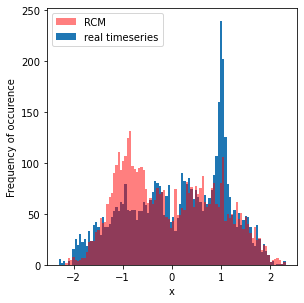

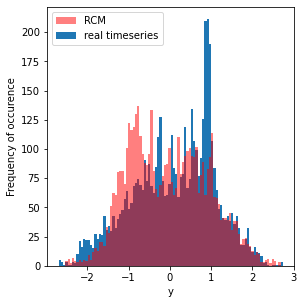

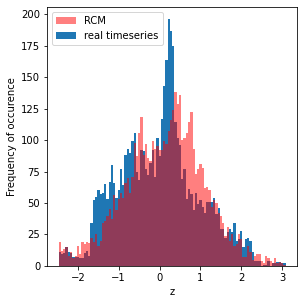

In [ ]:
plot_histogram(reservoir_forecast[:,0],target=validation_data[:,0],label='x')
plot_histogram(reservoir_forecast[:,1],target=validation_data[:,1],label='y')
plot_histogram(reservoir_forecast[:,2],target=validation_data[:,2],label='z')

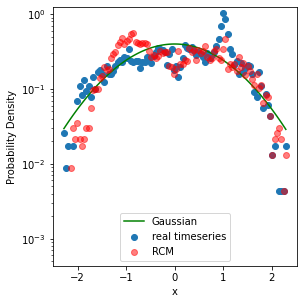

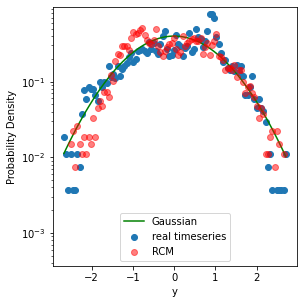

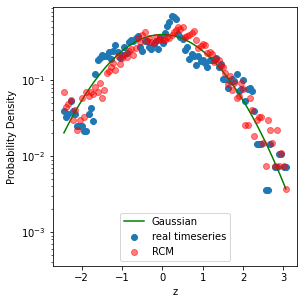

In [ ]:
plot_PDF(reservoir_forecast[:,0],target=validation_data[:,0],label='x')
plot_PDF(reservoir_forecast[:,1],target=validation_data[:,1],label='y')
plot_PDF(reservoir_forecast[:,2],target=validation_data[:,2],label='z')

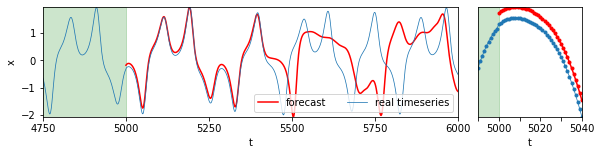

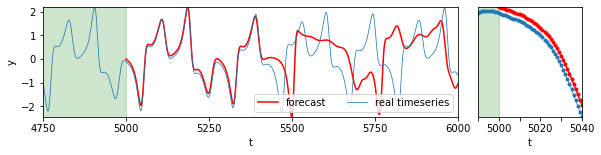

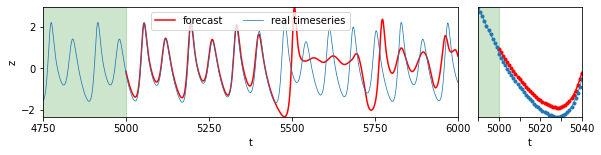

In [ ]:
plot_forecast(reservoir_forecast[:,0],target=validation_data[:,0],label='x',train_data=train_in[:,0])
plot_forecast(reservoir_forecast[:,1],target=validation_data[:,1],label='y',train_data=train_in[:,1])
plot_forecast(reservoir_forecast[:,2],target=validation_data[:,2],label='z',train_data=train_in[:,2])